## Exercise

In this exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

#### Importing libraries and data

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

# Optimization module in scipy
from scipy import optimize

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [2]:
# Load data
# The first two columns contains the exam scores and the third column contains the label.
data = np.loadtxt('Data/ex2data2.txt', delimiter=',')
x = data[:, 0:2]
y = data[:, 2]

#### Visualizing the data

First I am going to visualize the data by creating the function `plotData` which will generate a scatter plot, where the axes are the two test scores, and the positive (y = 1, passed) and negative (y = 0, failed) examples are shown with different markers.

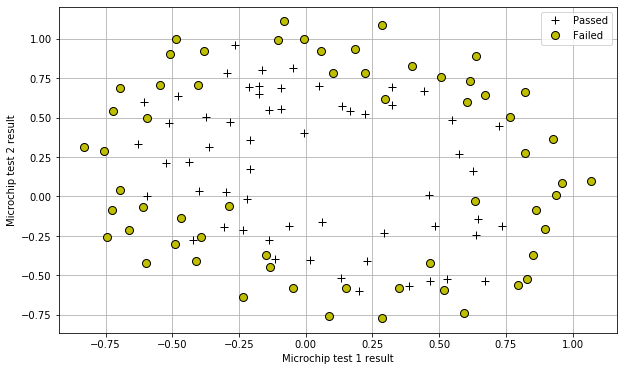

In [3]:
# Dividing the variable x into two different arrays: an array where the training examples have passed the Quality Assurance
# and a second array where the training examples have failed the Quality Assurance.
pos = x[np.where(y == 1)]
neg = x[np.where(y == 0)]

def plotData(x, y):
    plt.figure(figsize=(10,6))
    plt.plot(pos[:, 0], pos[:, 1], 'k+', ms=8)
    plt.plot(neg[:, 0], neg[:, 1], 'ko', mfc='y', ms=8) # mfc is the color of the circle, ms is the size of the marker
    plt.xlabel('Microchip test 1 result')
    plt.ylabel('Microchip test 2 result')
    plt.legend(['Passed', 'Failed'])
    plt.grid(True)
    
plotData(x, y)

From the scatter plot I can see that the best fit should be a polynomial function. This means that I will have to add more features and use regularization to make sure the decision boundary fits the data well.

#### Feature mapping

In order to fit the data well I will need to create more features from each data point. For this purpose the function `mapFeature` will be used to map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{mapFeature}(x_1, x_2) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

In [4]:
def mapFeature(x1col, x2col, degree = 6):
    output = np.ones((x1col.shape[0], 1)) # Creates column of 1's with the same number of rows as x1 and 1 column
    
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            # Reshapes term to be an array with same number of rows as x1 and 1 column
            term  = ( (x1col ** (i-j)) * (x2col ** (j)) ).reshape(output.shape[0], 1)
            output = np.hstack((output, term)) # stacks arrays column-wise
    return output

In [5]:
x = mapFeature(x[:, 0], x[:, 1])

As a result, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector.
By using more features we have to use regularization to avoid overfitting.

Note: In the `mapFeature` function the column of 1's for $x_0$ has already been added
    
#### Sigmoid function

Before implementing the function which will compute the cost function and gradient, I will write the sigmoid function.

In [6]:
def sigmoid(z):
    # First I convert the input into a numpy array - this way it accomodates the case that z is matrix or vector
    z = np.array(z)
    
    g = 1 / (1 + np.exp(-z)) # np.exp calculates the exponential of all values in array

    return g

#### Cost function and gradient

Now it is time to implement code to compute the cost function and gradient for regularized logistic regression. For this purporse I will create the function `costFunctionReg`.

The regularized cost function in logistic regression is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$
 
The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$

Note: I should not regularize the parameter $\theta_0$ in the cost function and in the gradient.

In [7]:
# Setting the variables m (number of training examples) and n (number of features)
m = y.shape[0]
n = x.shape[1]

def costFunctionReg(theta, x, y, lambda_):
    # Initializing the variable grad in order to be used below
    grad = np.zeros(theta.shape)

    h = sigmoid(x.dot(theta.T)) # Hypothesis
    
    # Cost function value
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(theta[1:]**2)
    
    # Gradient
    for i in range(len(theta)):
        if i == 0:
            grad[i] = (1 / m) * np.sum(h - y)
        else:
            grad[i] = (1 / m) * np.sum((h - y) * x[:, i]) + (lambda_ / m) * theta[i]
    
    return J, grad

As in the previous exercise, I will use the `scipy.optimize` module. I will use the same function `scipy.optimize.minimize` in order to minimize the cost function and find the best parameters $\theta$.

In [8]:
def optimizeTheta(costFunctionReg, theta, x, y, lambda_, options):
# I will use truncated Newton algorithm for optimization which is equivalent to MATLAB's fminunc
    result = optimize.minimize(costFunctionReg,
                               theta,
                               (x, y, lambda_),
                               jac = True,
                               method = 'TNC',
                               options = options)

    # The function returns an object `OptimizeResult`. The fun property of `OptimizeResult` object returns
    # the value of the cost function at optimized theta
    cost = result.fun

    # the optimized theta is in the x property of `OptimizeResult` object
    theta = result.x
    
    return cost, theta

In [9]:
# Initializing parameters
initial_theta = np.zeros(x.shape[1])

# Setting regularization parameter
lambda_ = 1

cost, theta = optimizeTheta(costFunctionReg, initial_theta, x, y, lambda_, {'maxiter': 100})

# Print theta to make sure it is working properly
print('Minimum cost found by optimize.minimize: {:.3f}'.format(cost))
print('Optimal theta values (only the first 3): {:.3f}, {:.3f}, {:.3f}'.format(*theta))

Minimum cost found by optimize.minimize: 0.529
Optimal theta values (only the first 3): 1.273, 0.625, 1.181


Now I will use use the optimal values for $\theta$ to visualize the decision boundary on the training data. For this I will use the function `plotDecisionBoundary` to draw the non-linear decision boundary.

<Figure size 864x720 with 0 Axes>

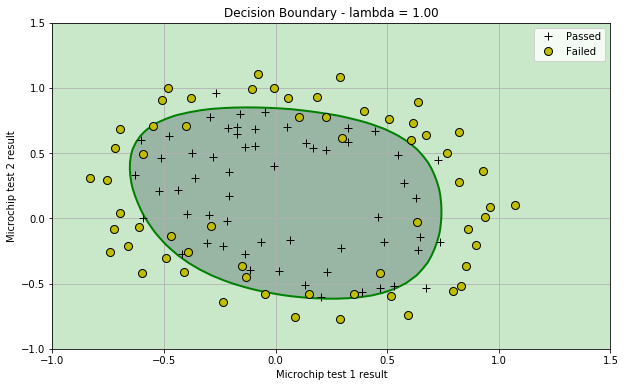

In [10]:
def plotDecisionBoundary(theta, x, y):
    # Plot Data (remember first column in X is the intercept)
    plotData(x[:, 1:3], y)
    
    # Here is the grid range
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    
    zvals = np.zeros((len(xvals),len(yvals)))
    
    # Evaluate z = theta*x over the grid
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            featuresij = mapFeature(np.array([xvals[i]]), np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta, featuresij.T)
    
    zvals = zvals.T # important to transpose z before calling contour

    plt.contour(xvals, yvals, zvals, levels=[0], linewidths=2, colors='g') # Plot line at z = 0
    plt.contourf(xvals, yvals, zvals, levels=[np.min(zvals), 0, np.max(zvals)], cmap='Greens', alpha=0.4)
    plt.title('Decision Boundary - lambda = %0.2f' % lambda_)

plt.figure(figsize=(12,10))
plotDecisionBoundary(theta, x, y)

Finally, I will evaluate the accuracy of the learned model by making predictions on the training set. For that I will write a function called `predict` which will produce “1” or “0” predictions given a dataset and parameters $\theta$. 

In [11]:
def predict(theta, x):
    # Initializing variable p with the same length as the number of training examples
    p = np.zeros(m)

    h = sigmoid(x.dot(theta.T)) # Hypothesis
    
    for i in range(m):
        if h[i] >= 0.5:
            p[i] = 1
        else:
            p[i] = 0
    
    return p

# Compute accuracy on our training set
p = predict(theta, x)

print('Model accuracy: {:.2f} %'.format(np.mean(p == y) * 100))

Model accuracy: 83.05 %


The prediction accuracy for the learned model on the training set is 83.05% which is good but still has quite some room for improvement. It needs improvement before being able to be used to make predictions on future microchips.